In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
path_dataset = '/content/gdrive/My Drive/Doutorado/Bases/GAMMA_training_data/multi-modality_images'
os.chdir(path_dataset)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Model
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import cv2
import urllib
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Activation, Flatten, Dropout,GlobalAveragePooling2D,Concatenate, concatenate
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
import time
import numpy as np
from keras.models import load_model
import os
import glob
from shutil import copy
from shutil import rmtree
import cv2
from google.colab import files
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models
import tensorflow as tf
from skimage import data, color, io, img_as_float
#from scipy.misc import imresize

# 3D CNNs

In [ ]:
!pip install classification-models-3D
!pip install keras_applications
from classification_models_3D.tfkeras import Classifiers

Load Images

In [ ]:
#import config_GAMMA
from utils_GAMMA_V2 import load_fundus_images
import numpy as np
IMAGE_SIZE=224
#Train SET
folder_fundus = 'dataset_fundus/train/fundus_images flip - 100 images/'
folder_fundus_2 = 'ROI_disco_50px'
conj=0

In [ ]:
#Test Set
val_path_dataset = '/content/gdrive/My Drive/Doutorado/Bases/GAMMA_val_data/multi-modality_images'
os.chdir(val_path_dataset)

folder_fundus = 'fundus_images'
folder_fundus_2 = 'ROI_disco_50px'
conj = 1# 1-->Load Images from test set
x_test_fundus,x_test_ROI = load_fundus_images(val_path_dataset,folder_fundus,folder_fundus_2,conj,IMAGE_SIZE)#
print(f"x_teste shape: {x_test_fundus.shape}")

100
x_teste shape: (100, 224, 224, 3)


# Load Model

In [ ]:
model = load_model('Modelos_CNN_Optuna/Teste_11/32_cnn.h5')#Dense169 - 224x224 - fundus
#model_roi = load_model('Modelos_CNN_Optuna/Teste_23/13_cnn.h5')
#model_oct = load_model('Modelos_CNN_Optuna/Testes_30_Trials/Teste_3/11_cnn.h5')

In [ ]:
model.summary()

# HeatMap Functions

In [ ]:
target_names = ['Normal', 'Early', 'Advanced']

In [ ]:
def get_heatmap(cnn_model, processed_image, class_idx):

    eps=1e-8

    gradModel = Model(
            inputs=[cnn_model.inputs],
            outputs=[cnn_model.get_layer('conv5_block32_concat').output, cnn_model.output])#Use Model.summary to see layer name you wish to visualize grad cams

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(processed_image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, class_idx]

    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (processed_image.shape[2], processed_image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")


#     # create a heatmap
#     heatmap = np.mean(conv_ouput_values, axis=-1)

#     # remove negative values
#     heatmap = np.maximum(heatmap, 0)

#     # normalize
#     heatmap /= heatmap.max()

    return heatmap

In [ ]:
def print_GradCAM(base_model, sample_image):
    # select the sample and read the corresponding image and label
    #sample_image = cv2.imread(path_image)

    # pre-process the image
    #sample_image = cv2.resize(sample_image, (224,224))
    #if sample_image.shape[2] ==1:
      #sample_image = np.dstack([sample_image, sample_image, sample_image])
    #sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    #sample_image = sample_image.astype(np.float32)/255.
#   sample_label = 1

    #since we pass only one image,we expand dim to include batch size 1
    sample_image_processed = np.expand_dims(sample_image, axis=0)

    # get the label predicted by our original model
    pred_label = np.argmax(base_model.predict(sample_image_processed), axis=-1)[0]
    print(base_model.predict(sample_image_processed))

    # get the heatmap for class activation map(CAM)
    heatmap = get_heatmap(base_model, sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
#     heatmap = 255 - heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # f,ax = plt.subplots(1,2, figsize=(16,6))
    plt.figure()
    f, ax = plt.subplots(ncols=2, figsize=(16, 6))

    #ax[1].imshow(heatmap)
    #ax[1].set_title("heatmap")
    #ax[1].axis('off')

    #superimpose the heatmap on the image
    sample_image_hsv = color.rgb2hsv(sample_image)
    heatmap = color.rgb2hsv(heatmap)

    alpha=0.7
    sample_image_hsv[..., 0] = heatmap[..., 0]
    sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

    img_masked = color.hsv2rgb(sample_image_hsv)

    # f,ax = plt.subplots(1,2, figsize=(16,6))
    ax[0].imshow(sample_image)
    #ax[0].set_title(f"original image (predicted label: {target_names[pred_label]})")
    ax[0].axis('off')

    ax[1].imshow(img_masked)
    #ax[1].set_title("superimposed image")
    ax[1].axis('off')

    plt.show()

# Fundus Images GRAD CAMs

In [ ]:
num_images = 10
#for i in range(num_images):
for i in range(num_images):
  #imagePath = os.path.sep.join([val_path_dataset,'fundus_images',images_files[i]])
  #print(imagePath)
  print_GradCAM(model, x_test_fundus[i])

In [ ]:
#ROI Grad Cams
for i in range(20, 30):
  print_GradCAM(model_roi, x_test_ROI[i])

# OCT Grad Cams

In [ ]:
model_oct.summary()

In [ ]:
###---lAYER-Name--to-visualize--###
LAYER_NAME='conv5_block16_concat'
# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model_oct.inputs], [model_oct.get_layer(LAYER_NAME).output, model_oct.output])
grad_model.summary()

In [ ]:
image = x_train_oct[0]
io_img=tf.expand_dims(image, axis=0)

###----index of the class
CLASS_INDEX=2
###--Compute GRADIENT
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(io_img)
    loss = predictions[:, CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

In [ ]:
# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1,2))
# Build a ponderated map of filters according to gradients importance
cam = np.zeros(output.shape[0:3], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, :, index]

<ipython-input-60-4a3e7fff9e24>:7: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 1.0, 'Overlay')

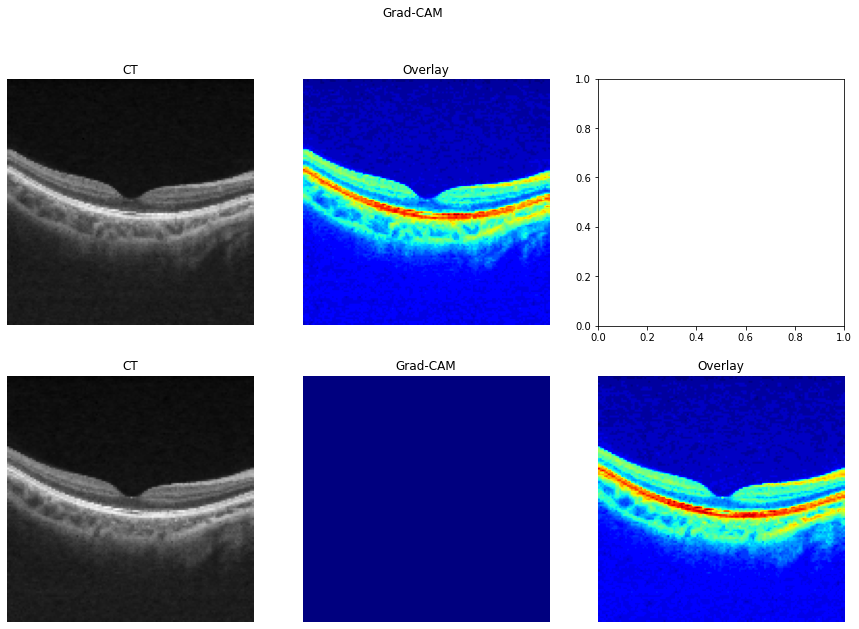

In [ ]:
from skimage.transform import resize
from matplotlib import pyplot as plt
capi=resize(cam,(64,128,128))
eps=1e-8
#print(capi.shape)
capi = np.maximum(capi,0)
heatmap = (capi - capi.min()) / (capi.max() - capi.min())
f, axarr = plt.subplots(2,3,figsize=(15,10));
f.suptitle('Grad-CAM')
slice_count=30
slice_count2=31

axial_ct_img=np.squeeze(image[slice_count, :,:])
axial_ct_img = cv2.cvtColor(axial_ct_img, cv2.COLOR_BGR2GRAY)
#axial_ct_img = (axial_ct_img/255.0).astype("float32")
axial_grad_cmap_img=np.squeeze(heatmap[slice_count,:, :])
# numer = axial_grad_cmap_img - np.min(axial_grad_cmap_img)
# denom = (axial_grad_cmap_img.max() - axial_grad_cmap_img.min()) + eps
# axial_grad_cmap_img = numer / denom
axial_grad_cmap_img = (axial_grad_cmap_img * 255).astype("uint8")

#coronal_ct_img=np.squeeze(image[:,slice_count2,:])
coronal_ct_img=np.squeeze(image[slice_count2,:,:])
coronal_ct_img = cv2.cvtColor(coronal_ct_img, cv2.COLOR_BGR2GRAY)
#coronal_ct_img = (coronal_ct_img/255.0).astype("float32")
coronal_grad_cmap_img=np.squeeze(heatmap[slice_count2,:,:])
coronal_grad_cmap_img = (coronal_grad_cmap_img * 255).astype("uint8")


img_plot = axarr[0,0].imshow(axial_ct_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('CT')

# img_plot = axarr[0,1].imshow(axial_grad_cmap_img, cmap='jet');
# axarr[0,1].axis('off')
# axarr[0,1].set_title('Grad-CAM')

axial_overlay=cv2.addWeighted(axial_ct_img,0.3,axial_grad_cmap_img, 0.6, 0)

img_plot = axarr[0,1].imshow(axial_overlay,cmap='jet');
axarr[0,1].axis('off')
axarr[0,1].set_title('Overlay')

#2º exemplo
img_plot = axarr[1,0].imshow(coronal_ct_img, cmap='gray');
axarr[1,0].axis('off')
axarr[1,0].set_title('CT')

img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap='jet');
axarr[1,1].axis('off')
axarr[1,1].set_title('Grad-CAM')

Coronal_overlay=cv2.addWeighted(coronal_ct_img,0.3,coronal_grad_cmap_img, 0.6, 0)

img_plot = axarr[1,2].imshow(Coronal_overlay,cmap='jet');
axarr[1,2].axis('off')
axarr[1,2].set_title('Overlay')